- [x] why do S11 and S22 response not seem to downshift with depth?
    - `"I am not sure why with depth it does not downshift; that's certainly counter-intuitive; I would check the data once more"`
- [x] are S11 and S22 close enough for the data to be considered calibrated for the cables?
    - `"they look calibrated but a deviation of more than 3dB suggests somewhat bad"`
- [x] where to get the Greenland refractive index model?
    - https://arxiv.org/abs/2304.06181
        - n=1.778 +/- 0.006
    - https://radio.uchicago.edu/wiki/images/6/62/20221121_Ice-model-Greenland.pdf
        - n(z) = 1 + 0.845 p(z)
        - p(z) = 917kg/m^3
- [x] verify the math looks right to Mohammad
- [ ] what frequency should I use as a reference for the RVEL calculation?
- [ ] what is the antenna impedance?
    - assuming 50 Ohms for now
- [ ] what is the distance between the antennas/holes?
- [ ] what are the NuRadioMC hardcoded values?


 ### Mohammad recipe for converting S21 to RVEL

$\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{\pi Z_f} \frac{G_i(w)}{n}}$

where

$G_i(w) = \frac{4 \pi R}{\lambda} |S_{21}(w)|$

and

$w = 0$ because the antennas were co-lowered

substituting $G_i(w)$ into the equation gives us:

$\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{\pi Z_f} \frac{\frac{4 \pi R}{\lambda} |S_{21}(w)|}{n}}$

which simplifies to:

$\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{Z_f} \frac{4R}{\lambda n} |S_{21}(w)|}$

- $\mathcal{H}_i(w)$ is the RVEL, Realized Vector Effective Length, at frequency $w$
- $\lambda$ is the wavelength
- $Z_A$ is the complex antenna impedance
- $\mathcal{R}(Z_A)$ is the real part of the antenna impedance
- $Z_f$ is the free space impedance, $Z_f = 377 \Omega$
- $R$ is the distance between the antennas
- $n$ is the refractive index of the medium between the antennas
- $S_{21}(w)$ is the S-parameter at frequency $w$
- $w = 0$ because the antennas were co-lowered

In [2]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d


In [3]:
# display plots in notebook
%matplotlib inline
import matplotlib.pyplot as plt

rf.stylely()

In [4]:
data_1m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_1m.s2p')
s11_1m_db = data_1m.s_db[:, 0, 0]
s12_1m_db = data_1m.s_db[:, 0, 1]
s21_1m_db = data_1m.s_db[:, 1, 0]
s22_1m_db = data_1m.s_db[:, 1, 1]

data_25m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_25m.s2p')
s11_25_db = data_25m.s_db[:, 0, 0]
s12_25_db = data_25m.s_db[:, 0, 1]
s21_25_db = data_25m.s_db[:, 1, 0]
s22_25_db = data_25m.s_db[:, 1, 1]

data_50m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_50m.s2p')
s11_50_db = data_50m.s_db[:, 0, 0]
s12_50_db = data_50m.s_db[:, 0, 1]
s21_50_db = data_50m.s_db[:, 1, 0]
s22_50_db = data_50m.s_db[:, 1, 1]

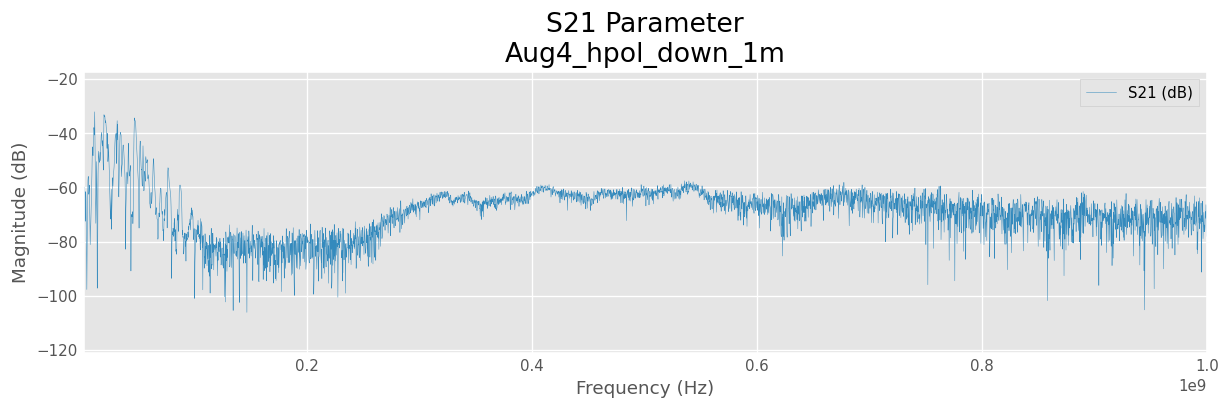

In [5]:
# plot the S21
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f, s21_1m_db, label='S21 (dB)', linewidth=.3)
plt.title('S21 Parameter\nAug4_hpol_down_1m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/S21 Parameter_Aug4_hpol_down_1m.png', dpi=600, bbox_inches='tight')

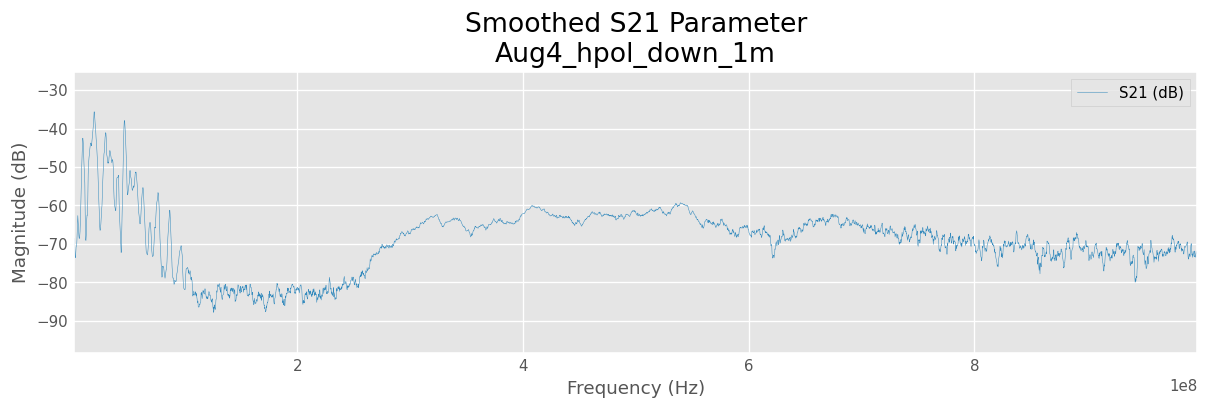

In [6]:
# smooth and plot the S21 curve
s21_1m_db_smooth = np.convolve(s21_1m_db, np.ones(10)/10, mode='valid')
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f[:-9], s21_1m_db_smooth, label='S21 (dB)', linewidth=.3)
plt.title('Smoothed S21 Parameter\nAug4_hpol_down_1m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/Smoothed S21 Parameter_Aug4_hpol_down_1m.png', dpi=600, bbox_inches='tight')

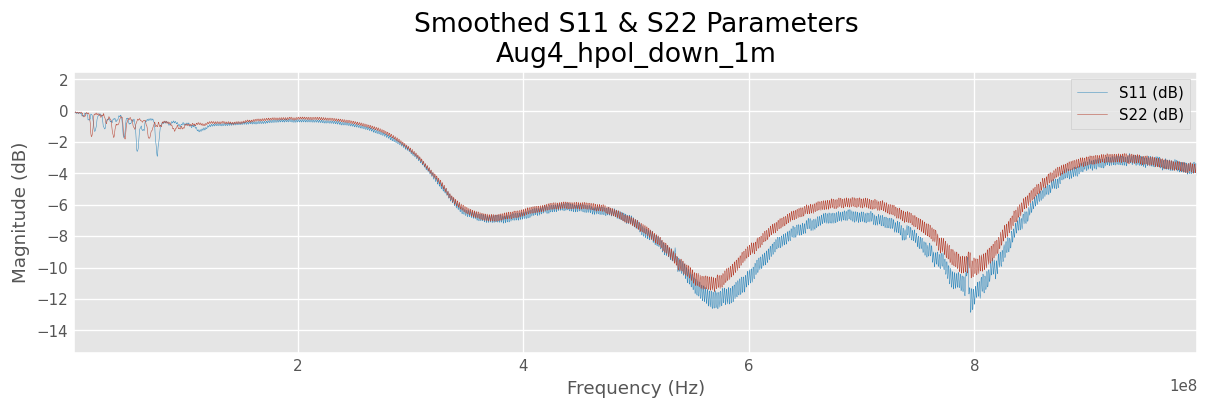

In [7]:
# smooth the S11 and S22 curves
s11_1m_db_smooth = np.convolve(s11_1m_db, np.ones(10)/10, mode='valid')
s22_1m_db_smooth = np.convolve(s22_1m_db, np.ones(10)/10, mode='valid')

# plot the smoothed S11 and S22 curves
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f[:-9], s11_1m_db_smooth, label='S11 (dB)', linewidth=.3)
plt.plot(data_1m.frequency.f[:-9], s22_1m_db_smooth, label='S22 (dB)', linewidth=.3)
plt.title('Smoothed S11 & S22 Parameters\nAug4_hpol_down_1m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/Smoothed S11 & S22 Parameters_Aug4_hpol_down_1m.png', dpi=600, bbox_inches='tight')


In [8]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])  # set colorblind cycle

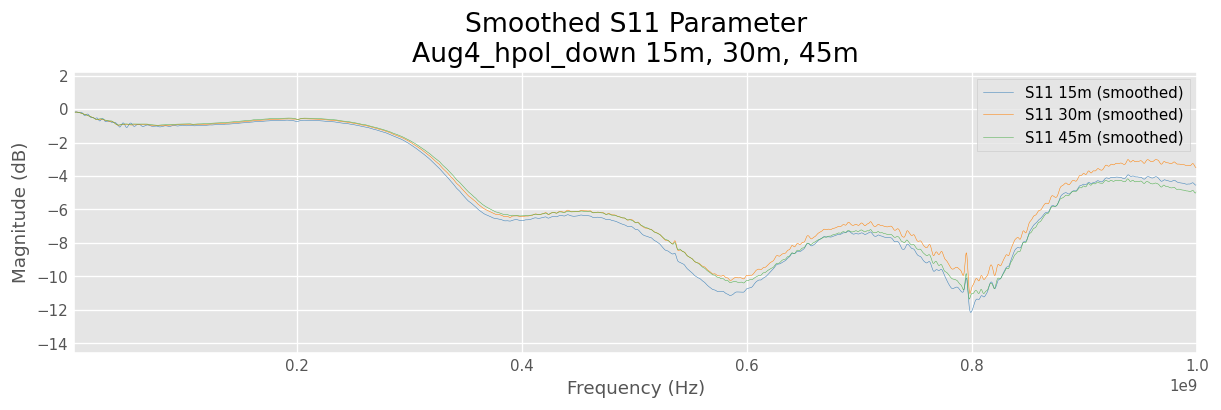

In [11]:
# plot the S11 curves for 15, 30, and 45m

# get the data
data_15m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_15m.s2p')
s11_15m_db = data_15m.s_db[:, 0, 0]
s22_15m_db = data_15m.s_db[:, 1, 1]
data_30m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_30m.s2p')
s11_30m_db = data_30m.s_db[:, 0, 0]
s22_30m_db = data_30m.s_db[:, 1, 1]
data_45m = rf.Network('Data/Port1inNWhole_Port2inShole_ST35_HPOL_VNA/Aug4_hpol_down_45m.s2p')
s11_45m_db = data_45m.s_db[:, 0, 0]
s22_45m_db = data_45m.s_db[:, 1, 1]

# smooth the S11 curves
# s11_15m_db_smooth = np.convolve(s11_15m_db, np.ones(10)/10, mode='valid')
# s22_15m_db_smooth = np.convolve(s22_15m_db, np.ones(10)/10, mode='valid')
# s11_30m_db_smooth = np.convolve(s11_30m_db, np.ones(10)/10, mode='valid')
# s22_30m_db_smooth = np.convolve(s22_30m_db, np.ones(10)/10, mode='valid')
# s11_45m_db_smooth = np.convolve(s11_45m_db, np.ones(10)/10, mode='valid')
# s22_45m_db_smooth = np.convolve(s22_45m_db, np.ones(10)/10, mode='valid')

# smooth the S11 curves using gaussian filter
sigma = 5  # Standard deviation for Gaussian kernel
s11_15m_db_smooth = gaussian_filter1d(s11_15m_db, sigma)
s11_30m_db_smooth = gaussian_filter1d(s11_30m_db, sigma)
s11_45m_db_smooth = gaussian_filter1d(s11_45m_db, sigma)

# plot the smoothed S11 curves
plt.figure(figsize=(12, 3))
plt.plot(data_15m.frequency.f, s11_15m_db_smooth, label='S11 15m (smoothed)', linewidth=.3)
plt.plot(data_30m.frequency.f, s11_30m_db_smooth, label='S11 30m (smoothed)', linewidth=.3)
plt.plot(data_45m.frequency.f, s11_45m_db_smooth, label='S11 45m (smoothed)', linewidth=.3)
plt.title('Smoothed S11 Parameter\nAug4_hpol_down 15m, 30m, 45m')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.savefig('Images/Smoothed S11 Parameters_Aug4_hpol_down_15_30_45m.png', dpi=600, bbox_inches='tight')

In [9]:
    # combine the three images into one stacked image
from PIL import Image
def stack_images_vertically(image_paths, output_path):
    images = [Image.open(path) for path in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_height = sum(heights)
    max_width = max(widths)

    new_image = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        new_image.paste(img, (0, y_offset))
        y_offset += img.height

    new_image.save(output_path)
# Stack the images
image_paths = [
    'Images/S11 & S22 Parameters_Aug4_hpol_down_1m.png',
    'Images/S11 & S22 Parameters_Aug4_hpol_down_25m.png',
    'Images/S11 & S22 Parameters_Aug4_hpol_down_50m.png'
]
output_path = 'Images/S11 & S22 Parameters_Aug4_hpol_down_stacked.png'
stack_images_vertically(image_paths, output_path)


In [10]:
# plot the S11 curves for 15, 30, and 45m

$\mathcal{H}_i(w) = \lambda \sqrt{\frac{\mathcal{R}(Z_A)}{Z_f} \frac{4R}{\lambda n} |S_{21}(w)|}$

- $\mathcal{H}_i(w)$ is the RVEL, Realized Vector Effective Length, at frequency $w$
- $\lambda$ is the wavelength
- $Z_A$ is the complex antenna impedance
- $\mathcal{R}(Z_A)$ is the real part of the antenna impedance
- $Z_f$ is the free space impedance, $Z_f = 377 \Omega$
- $R$ is the distance between the antennas
- $n$ is the refractive index of the medium between the antennas
- $S_{21}(w)$ is the S-parameter at frequency $w$
- $w = 0$ because the antennas were co-lowered

In [11]:
# Constants we know
Z_f = 377  # Free space impedance in Ohms
n = 1.778  # Refractive index of the medium (Greenland ice)

# Constants we need to check
R = 1.0  # Distance between antennas in meters
Z_A = 50.0  # Antenna impedance in Ohms (assumed, needs verification)

# Constants we might want to change
freq = 500e6  # Frequency in Hz
wavelength = 3e8 / freq  # Wavelength in meters
# Calculate the real part of the antenna impedance
R_A = Z_A  # Assuming the antenna impedance is purely resistive for simplicity

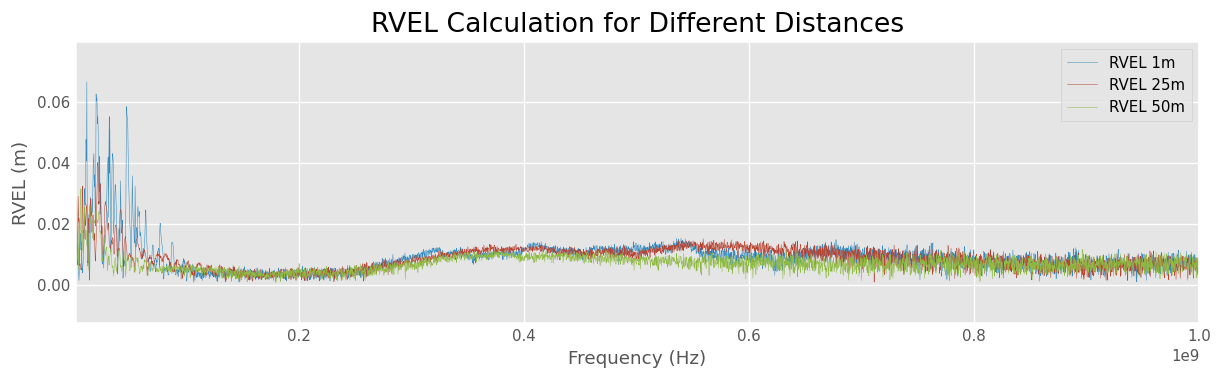

In [13]:
# Calculate the Realized Vector Effective Length
def RVEL(S21, R, Z_A, n, Z_f, wavelength):
    R_A = Z_A  # Real part of the antenna impedance
    return wavelength * np.sqrt((R_A / Z_f) * (4 * R / (wavelength * n)) * np.abs(S21))
# Calculate RVEL for each S21 value
RVEL_1m = RVEL(data_1m.s[:, 1, 0], R, Z_A, n, Z_f, wavelength)
RVEL_25m = RVEL(data_25m.s[:, 1, 0], R, Z_A, n, Z_f, wavelength)
RVEL_50m = RVEL(data_50m.s[:, 1, 0], R, Z_A, n, Z_f, wavelength)
# Plot the RVEL results
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f, RVEL_1m, label='RVEL 1m', linewidth=.3)
plt.plot(data_25m.frequency.f, RVEL_25m, label='RVEL 25m', linewidth=.3)
plt.plot(data_50m.frequency.f, RVEL_50m, label='RVEL 50m', linewidth=.3)
plt.title('RVEL Calculation for Different Distances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RVEL (m)')
plt.legend()
plt.savefig('Images/RVEL_Calculation_Aug4_hpol_down.png', dpi=600, bbox_inches='tight')
plt.show()

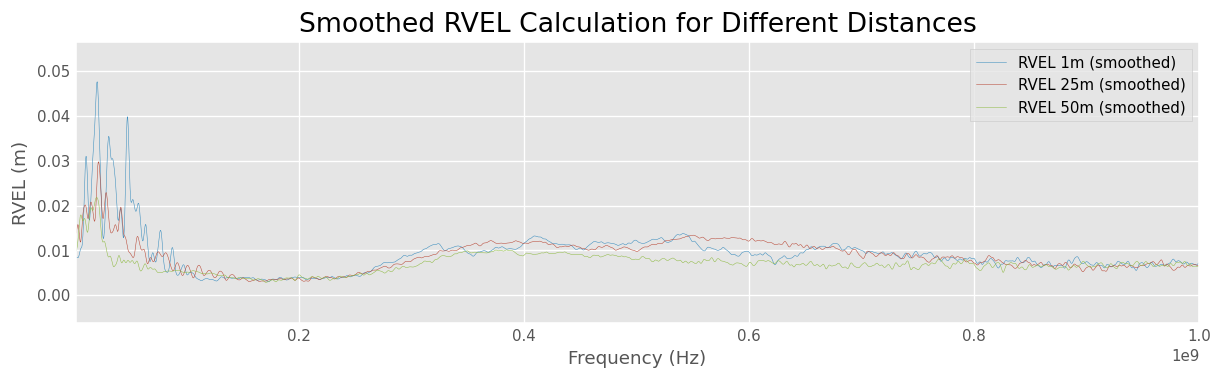

In [17]:
# smooth the RVEL curves
sigma = 5  # Standard deviation for Gaussian kernel
RVEL_1m_smooth = gaussian_filter1d(RVEL_1m, sigma)
RVEL_25m_smooth = gaussian_filter1d(RVEL_25m, sigma)
RVEL_50m_smooth = gaussian_filter1d(RVEL_50m, sigma)
# Plot the smoothed RVEL results
plt.figure(figsize=(12, 3))
plt.plot(data_1m.frequency.f, RVEL_1m_smooth, label='RVEL 1m (smoothed)', linewidth=.3)
plt.plot(data_25m.frequency.f, RVEL_25m_smooth, label='RVEL 25m (smoothed)', linewidth=.3)
plt.plot(data_50m.frequency.f, RVEL_50m_smooth, label='RVEL 50m (smoothed)', linewidth=.3)
plt.title('Smoothed RVEL Calculation for Different Distances')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RVEL (m)')
plt.legend()
plt.savefig('Images/Smoothed_RVEL_Calculation_Aug4_hpol_down.png', dpi=600, bbox_inches='tight')